In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('../data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('../data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('../data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('../data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('../data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [9]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [10]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [11]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params

In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib

In [13]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(200, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [14]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode

train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.0026939774600629332


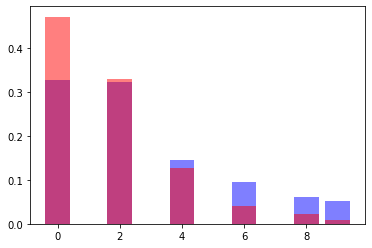

0.0026939774600629332

In [15]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [17]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999974
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434877979
3: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068794
4: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146714084
5: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434877979
6: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733648
7: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
8: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.996508454399599
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733648
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.996508454399599
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434877979
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068794
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146714084
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
15: FEAT_A: 3110 FEAT_B: 3010 - Correlation: 

111: FEAT_A: 1b54d27f FEAT_B: Watering Hole (Activity)_2010 - Correlation: 0.9999999999999998
112: FEAT_A: 9b4001e4 FEAT_B: f5b8c21a - Correlation: 0.9976837802056979
113: FEAT_A: 9b4001e4 FEAT_B: 58a0de5c - Correlation: 0.999915936221622
114: FEAT_A: 9b4001e4 FEAT_B: Air Show_2030 - Correlation: 0.9976837802056979
115: FEAT_A: 9b4001e4 FEAT_B: Air Show_3121 - Correlation: 0.999915936221622
116: FEAT_A: 9b4001e4 FEAT_B: Air Show_3021 - Correlation: 1.0
117: FEAT_A: a8876db3 FEAT_B: Cart Balancer (Assessment)_3021 - Correlation: 1.0
118: FEAT_A: df4940d3 FEAT_B: 67439901 - Correlation: 0.9999351626435933
119: FEAT_A: df4940d3 FEAT_B: Bottle Filler (Activity)_3010 - Correlation: 0.9999351626435933
120: FEAT_A: df4940d3 FEAT_B: Bottle Filler (Activity)_3110 - Correlation: 0.9999999999999928
121: FEAT_A: b7dc8128 FEAT_B: 4b5efe37 - Correlation: 0.9980151285383945
122: FEAT_A: b7dc8128 FEAT_B: All Star Sorting_2000 - Correlation: 1.0
123: FEAT_A: b7dc8128 FEAT_B: All Star Sorting_4010 - Cor

213: FEAT_A: cf82af56 FEAT_B: Scrub-A-Dub_4070 - Correlation: 1.0
214: FEAT_A: 5e812b27 FEAT_B: Sandcastle Builder (Activity)_4030 - Correlation: 0.9999999999999966
215: FEAT_A: bd701df8 FEAT_B: 49ed92e9 - Correlation: 0.999310913888882
216: FEAT_A: bd701df8 FEAT_B: Watering Hole (Activity)_3110 - Correlation: 1.0
217: FEAT_A: bd701df8 FEAT_B: Watering Hole (Activity)_3010 - Correlation: 0.999310913888882
218: FEAT_A: 9e4c8c7b FEAT_B: 363d3849 - Correlation: 0.9992130941883672
219: FEAT_A: 9e4c8c7b FEAT_B: All Star Sorting_3110 - Correlation: 1.0
220: FEAT_A: 9e4c8c7b FEAT_B: All Star Sorting_3010 - Correlation: 0.9992130941883672
221: FEAT_A: 56817e2b FEAT_B: cb6010f8 - Correlation: 0.9990475739429509
222: FEAT_A: 56817e2b FEAT_B: 47026d5f - Correlation: 0.9993683693704701
223: FEAT_A: 56817e2b FEAT_B: Chow Time_3121 - Correlation: 0.9990475739429509
224: FEAT_A: 56817e2b FEAT_B: Chow Time_2030 - Correlation: 0.999999999999996
225: FEAT_A: 56817e2b FEAT_B: Chow Time_3021 - Correlation

316: FEAT_A: 3d63345e FEAT_B: Cart Balancer (Assessment)_4035 - Correlation: 0.9999999999999211
317: FEAT_A: 04df9b66 FEAT_B: 5290eab1 - Correlation: 0.9998190477471364
318: FEAT_A: 04df9b66 FEAT_B: Cauldron Filler (Assessment)_3120 - Correlation: 0.9998190477471364
319: FEAT_A: 04df9b66 FEAT_B: Cauldron Filler (Assessment)_3020 - Correlation: 1.0
320: FEAT_A: bd612267 FEAT_B: Chest Sorter (Assessment)_4070 - Correlation: 0.999999999999997
321: FEAT_A: 9ee1c98c FEAT_B: Sandcastle Builder (Activity)_4021 - Correlation: 0.999999999999956
322: FEAT_A: fcfdffb6 FEAT_B: Flower Waterer (Activity)_4022 - Correlation: 0.9999999999999937
323: FEAT_A: ecaab346 FEAT_B: b2e5b0f1 - Correlation: 0.9998494646045443
324: FEAT_A: ecaab346 FEAT_B: b74258a0 - Correlation: 1.0
325: FEAT_A: ecaab346 FEAT_B: Cart Balancer (Assessment)_2010 - Correlation: 0.9998494646045443
326: FEAT_A: ecaab346 FEAT_B: Cart Balancer (Assessment)_3121 - Correlation: 1.0
327: FEAT_A: ecaab346 FEAT_B: Cart Balancer (Assessment

420: FEAT_A: ecc6157f FEAT_B: Cart Balancer (Assessment)_4080 - Correlation: 1.0
421: FEAT_A: 1cc7cfca FEAT_B: All Star Sorting_4030 - Correlation: 0.9999999999999827
422: FEAT_A: 8fee50e2 FEAT_B: Bird Measurer (Assessment)_4020 - Correlation: 0.9999999999999911
423: FEAT_A: 7372e1a5 FEAT_B: Chow Time_4070 - Correlation: 0.9999999999999594
424: FEAT_A: 5b49460a FEAT_B: 155f62a4 - Correlation: 1.0
425: FEAT_A: 5b49460a FEAT_B: Chest Sorter (Assessment)_2000 - Correlation: 1.0
426: FEAT_A: 5b49460a FEAT_B: Chest Sorter (Assessment)_2020 - Correlation: 1.0
427: FEAT_A: 25fa8af4 FEAT_B: Mushroom Sorter (Assessment)_4100 - Correlation: 0.9999999999999865
428: FEAT_A: cc5087a3 FEAT_B: Crystals Rule_4010 - Correlation: 0.9999999999999882
429: FEAT_A: 7d093bf9 FEAT_B: Chow Time_2000 - Correlation: 1.0
430: FEAT_A: 4e5fc6f5 FEAT_B: Cart Balancer (Assessment)_4090 - Correlation: 0.999999999999939
431: FEAT_A: 51311d7a FEAT_B: Dino Drink_2000 - Correlation: 1.0
432: FEAT_A: 46cd75b4 FEAT_B: Chick

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
1b54d27f 0.0007348784624081402 0.0
7fd1ac25 0.01978518937252685 0.0
0ce40006 0.0008479366873940079 0.0
dcb1663e 0.0 0.0
4074bac2 0.0 0.0
a8cc6fec 0.0 0.0
003cd2ee 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
e4d32835 0.0013001695873374789 0.0
6aeafed4 0.14703222159412097 0.008 0.0
29a42aea 0.004070096099491238 0.0
2ec694de 0.008988128886376484 0.0
ecc6157f 0.007292255511588468 0.0
bfc77bd6 0.012832108535895986 0.0
17ca3959 0.0 0.0
5dc079d8 0.0 0.0
13f56524 0.04392312040700961 0.0
611485c5 0.0013566986998304127 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
119b5b02 0.0002826455624646693 0.0
01ca3a3c 0.0004522328999434709 0.0
Dino Drink_4080 0.0009044657998869418 0.0
Pan Balance_2010 0.0 0.0
Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Fireworks (Activity)_4080 0.0013566986998304127 0.0
Watering Hole (Activity)_2010 0.0007348784624081402 0.

In [19]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 364)

In [20]:
pseudolabels = pd.read_csv('for_pseudolabeling.csv', index_col=0)

reduce_train = pd.concat([reduce_train, reduce_test], axis=0, sort=True).reset_index().drop(columns='index')

In [21]:
np.argmax(reduce_train.columns == 'accuracy_group')

894

In [22]:
reduce_train.iloc[-1000:, 894] = np.mean(pseudolabels.values, axis=1)

In [23]:
reduce_train['accuracy_group']

0        3.000000
1        0.000000
2        3.000000
3        2.000000
4        3.000000
           ...   
18685    2.546667
18686    0.626667
18687    2.106667
18688    1.486667
18689    1.490000
Name: accuracy_group, Length: 18690, dtype: float64

In [24]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]

features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]
categoricals = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in categoricals]

In [25]:
coefs = [1.2641475186120315, 1.7026714246402963, 1.9379324492578078]

def soft2hard(o):
    if o < coefs[0]: return 0
    elif o < coefs[1]: return 1
    elif o < coefs[2]: return 2
    else: return 3
    
_targs = np.array([soft2hard(o.item()) for o in reduce_train.iloc[-1000:, 894].values])

In [26]:
reduce_train.iloc[-1000:, 894] = _targs

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02211	valid_1's rmse: 1.05865
[200]	training's rmse: 0.950108	valid_1's rmse: 1.00872
[300]	training's rmse: 0.916284	valid_1's rmse: 0.99146
[400]	training's rmse: 0.893253	valid_1's rmse: 0.983233
[500]	training's rmse: 0.875003	valid_1's rmse: 0.978582
[600]	training's rmse: 0.859427	valid_1's rmse: 0.975666
[700]	training's rmse: 0.845484	valid_1's rmse: 0.973587
[800]	training's rmse: 0.832464	valid_1's rmse: 0.972266
[900]	training's rmse: 0.82024	valid_1's rmse: 0.971262
[1000]	training's rmse: 0.808797	valid_1's rmse: 0.970174
[1100]	training's rmse: 0.797807	valid_1's rmse: 0.969587
[1200]	training's rmse: 0.787406	valid_1's rmse: 0.969515
Early stopping, best iteration is:
[1158]	training's rmse: 0.791722	valid_1's rmse: 0.969269
Partial score of fold 0 is: 0.6050465006282668
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.023	valid_1's rmse: 1.04242
[

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85505	val-rmse:1.85617
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01376	val-rmse:1.15019
[200]	train-rmse:0.746768	val-rmse:1.00847
[300]	train-rmse:0.633912	val-rmse:0.983487
[400]	train-rmse:0.569835	val-rmse:0.977655
[500]	train-rmse:0.533405	val-rmse:0.975941
[600]	train-rmse:0.507246	val-rmse:0.975562
[700]	train-rmse:0.482943	val-rmse:0.975174
Stopping. Best iteration:
[667]	train-rmse:0.49101	val-rmse:0.975019

Partial score of fold 0 is: 0.5948825675541498
[0]	train-rmse:1.85501	val-rmse:1.85625
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.0127	val-rmse:1.14883
[200]	train-rmse:0.734931	val-rmse:1.0014
[300]	train-rmse:0.617444	val-rmse:0.97728
[400]	train-rmse:0.55516	val-rmse:0.974582
[500]	train-rmse:0.516167	val-rmse:0.974529
S

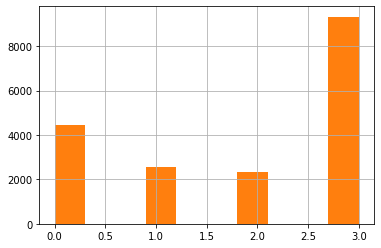

In [27]:
# cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01305	valid_1's rmse: 1.03181
[200]	training's rmse: 0.945222	valid_1's rmse: 0.984044
[300]	training's rmse: 0.911401	valid_1's rmse: 0.968491
[400]	training's rmse: 0.888672	valid_1's rmse: 0.962504
[500]	training's rmse: 0.870158	valid_1's rmse: 0.959807
[600]	training's rmse: 0.854535	valid_1's rmse: 0.958539
[700]	training's rmse: 0.84055	valid_1's rmse: 0.957503
[800]	training's rmse: 0.827614	valid_1's rmse: 0.957132
[900]	training's rmse: 0.815627	valid_1's rmse: 0.957259
Early stopping, best iteration is:
[803]	training's rmse: 0.827204	valid_1's rmse: 0.957065
Partial score of fold 0 is: 0.5929414645971569
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01249	valid_1's rmse: 1.0395
[200]	training's rmse: 0.94475	valid_1's rmse: 0.992346
[300]	training's rmse: 0.91194	valid_1's rmse: 0.97736
[400]	training's rmse: 0.889299	valid_1's rmse: 0.970344
[500]	training's rmse: 0.870961	valid_1's rmse: 0.966998
[600]	training's rmse: 0.855208	valid_1's rmse: 0.965146
[700]	training's rmse: 0.840887	valid_1's rmse: 0.964
[800]	training's rmse: 0.82792	valid_1's rmse: 0.963541
[900]	training's rmse: 0.815865	valid_1's rmse: 0.963003
[1000]	training's rmse: 0.804572	valid_1's rmse: 0.962553
[1100]	training's rmse: 0.793784	valid_1's rmse: 0.962354
Early stopping, best iteration is:
[1062]	training's rmse: 0.797796	valid_1's rmse: 0.962251
Partial score of fold 1 is: 0.6000106301954551
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01729	valid_1's rmse: 1.02876
[200]	training's rmse: 0.949928	valid_1's rmse: 0.974635
[300]	training's rmse: 0.917069	valid_1's rmse: 0.956151
[400]	training's rmse: 0.894212	valid_1's rmse: 0.948547
[500]	training's rmse: 0.876171	valid_1's rmse: 0.945127
[600]	training's rmse: 0.860469	valid_1's rmse: 0.943162
[700]	training's rmse: 0.846484	valid_1's rmse: 0.941769
[800]	training's rmse: 0.83338	valid_1's rmse: 0.941282
[900]	training's rmse: 0.821001	valid_1's rmse: 0.940844
[1000]	training's rmse: 0.80934	valid_1's rmse: 0.940817
Early stopping, best iteration is:
[955]	training's rmse: 0.814463	valid_1's rmse: 0.940695
Partial score of fold 2 is: 0.6215984724446693
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01168	valid_1's rmse: 1.03453
[200]	training's rmse: 0.944654	valid_1's rmse: 0.987451
[300]	training's rmse: 0.912303	valid_1's rmse: 0.971961
[400]	training's rmse: 0.889723	valid_1's rmse: 0.964749
[500]	training's rmse: 0.871475	valid_1's rmse: 0.961265
[600]	training's rmse: 0.855809	valid_1's rmse: 0.958868
[700]	training's rmse: 0.841751	valid_1's rmse: 0.957513
[800]	training's rmse: 0.828822	valid_1's rmse: 0.956187
[900]	training's rmse: 0.816566	valid_1's rmse: 0.95549
[1000]	training's rmse: 0.805144	valid_1's rmse: 0.955214
[1100]	training's rmse: 0.794316	valid_1's rmse: 0.954884
Early stopping, best iteration is:
[1075]	training's rmse: 0.796979	valid_1's rmse: 0.954803
Partial score of fold 3 is: 0.6076124342224567
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01306	valid_1's rmse: 1.03289
[200]	training's rmse: 0.944512	valid_1's rmse: 0.985525
[300]	training's rmse: 0.911071	valid_1's rmse: 0.97214
[400]	training's rmse: 0.888318	valid_1's rmse: 0.966954
[500]	training's rmse: 0.869991	valid_1's rmse: 0.964468
[600]	training's rmse: 0.854081	valid_1's rmse: 0.96294
[700]	training's rmse: 0.839852	valid_1's rmse: 0.962457
[800]	training's rmse: 0.826981	valid_1's rmse: 0.962594
Early stopping, best iteration is:
[715]	training's rmse: 0.837874	valid_1's rmse: 0.96232
Partial score of fold 4 is: 0.5944376294904521
Our oof cohen kappa score is:  0.6025067808669881
[0]	train-rmse:1.8343	val-rmse:1.83576
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[100]	train-rmse:0.990514	val-rmse:1.14397
[200]	train-rmse:0.708751	val-rmse:1.00378
[300]	train-rmse:0.593842	val-rmse:0.980222
[400]	train-rmse:0.532215	val-rmse:0.976547
[500]	train-rmse:0.493079	val-rmse:0.976451
[600]	train-rmse:0.466239	val-rmse:0.976878
Stopping. Best iteration:
[509]	train-rmse:0.49042	val-rmse:0.976361

Partial score of fold 0 is: 0.5780717661210506
[0]	train-rmse:1.83433	val-rmse:1.8355
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.989351	val-rmse:1.14073
[200]	train-rmse:0.713247	val-rmse:1.00398
[300]	train-rmse:0.593934	val-rmse:0.980075
[400]	train-rmse:0.526608	val-rmse:0.975913
[500]	train-rmse:0.488021	val-rmse:0.975284
Stopping. Best iteration:
[472]	train-rmse:0.497045	val-rmse:0.975212

Partial score of fold 1 is: 0.5838636262366934
[0]	train-rmse:1.83452	val-rmse:1.83527
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.992766	val-rmse:1.12985
[200]	train-rmse:0.717236	val-rmse:0.986409
[300]	train-rmse:0.604476	val-rmse:0.961644
[400]	train-rmse:0.543962	val-rmse:0.958755
[500]	train-rmse:0.511792	val-rmse:0.958973
Stopping. Best iteration:
[414]	train-rmse:0.538348	val-rmse:0.958578

Partial score of fold 2 is: 0.5931657046042409
[0]	train-rmse:1.83445	val-rmse:1.83577
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.984832	val-rmse:1.12959
[200]	train-rmse:0.701668	val-rmse:0.987725
[300]	train-rmse:0.58585	val-rmse:0.965562
[400]	train-rmse:0.525423	val-rmse:0.962632
[500]	train-rmse:0.487095	val-rmse:0.962826
Stopping. Best iteration:
[403]	train-rmse:0.523978	val-rmse:0.962597

Partial score of fold 3 is: 0.5919871575539102
[0]	train-rmse:1.83455	val-rmse:1.83526
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988696	val-rmse:1.13803
[200]	train-rmse:0.709556	val-rmse:0.998482
[300]	train-rmse:0.595364	val-rmse:0.974106
[400]	train-rmse:0.536609	val-rmse:0.971258
[500]	train-rmse:0.498554	val-rmse:0.972259
Stopping. Best iteration:
[411]	train-rmse:0.531903	val-rmse:0.971133

Partial score of fold 4 is: 0.5839058215568564
Our oof cohen kappa score is:  0.5862517587455798

(18690, 369)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               74000     
_________________________________________________________________
layer_normalization_4 (Layer (None, 200)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_5 (Layer (None, 100)               200       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)  

14848/14952 [============================>.] - ETA: 0s - loss: 0.9288
Epoch 00025: val_loss did not improve from 0.99345
14952/14952 [==============================] - 2s 159us/sample - loss: 0.9285 - val_loss: 1.0232
Epoch 26/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9229
Epoch 00026: val_loss did not improve from 0.99345
14952/14952 [==============================] - 2s 158us/sample - loss: 0.9222 - val_loss: 1.0029
Epoch 27/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.9193
Epoch 00027: val_loss improved from 0.99345 to 0.98013, saving model to nn_model.w8
14952/14952 [==============================] - 2s 156us/sample - loss: 0.9229 - val_loss: 0.9801
Epoch 28/100
14624/14952 [============================>.] - ETA: 0s - loss: 0.9109
Epoch 00028: val_loss did not improve from 0.98013
14952/14952 [==============================] - 2s 156us/sample - loss: 0.9104 - val_loss: 1.0117
Epoch 29/100
14944/14952 [============================>.

Epoch 4/100
14880/14952 [============================>.] - ETA: 0s - loss: 1.1964
Epoch 00004: val_loss improved from 1.03402 to 1.01245, saving model to nn_model.w8
14952/14952 [==============================] - 3s 169us/sample - loss: 1.1968 - val_loss: 1.0124
Epoch 5/100
14656/14952 [============================>.] - ETA: 0s - loss: 1.1611
Epoch 00005: val_loss improved from 1.01245 to 1.00700, saving model to nn_model.w8
14952/14952 [==============================] - 3s 171us/sample - loss: 1.1611 - val_loss: 1.0070
Epoch 6/100
14944/14952 [============================>.] - ETA: 0s - loss: 1.1290
Epoch 00006: val_loss improved from 1.00700 to 1.00626, saving model to nn_model.w8
14952/14952 [==============================] - 2s 162us/sample - loss: 1.1290 - val_loss: 1.0063
Epoch 7/100
14656/14952 [============================>.] - ETA: 0s - loss: 1.1122
Epoch 00007: val_loss improved from 1.00626 to 1.00367, saving model to nn_model.w8
14952/14952 [==============================] 

Epoch 38/100
14688/14952 [============================>.] - ETA: 0s - loss: 0.8253
Epoch 00038: val_loss did not improve from 0.95305
14952/14952 [==============================] - 2s 158us/sample - loss: 0.8248 - val_loss: 0.9704
Partial score of fold 1 is: 0.6070792872430903
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 200)               74000     
_________________________________________________________________
layer_normalization_12 (Laye (None, 200)               400       
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               20100     
_________________________________________________________________
layer_normalization_13 (Laye (None, 100)

Epoch 25/100
14784/14952 [============================>.] - ETA: 0s - loss: 0.9380
Epoch 00025: val_loss did not improve from 0.94182
14952/14952 [==============================] - 2s 163us/sample - loss: 0.9383 - val_loss: 0.9532
Epoch 26/100
14688/14952 [============================>.] - ETA: 0s - loss: 0.9229
Epoch 00026: val_loss did not improve from 0.94182
14952/14952 [==============================] - 2s 164us/sample - loss: 0.9222 - val_loss: 0.9503
Epoch 27/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9208
Epoch 00027: val_loss did not improve from 0.94182
14952/14952 [==============================] - 2s 163us/sample - loss: 0.9216 - val_loss: 0.9672
Epoch 28/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.9155
Epoch 00028: val_loss improved from 0.94182 to 0.93561, saving model to nn_model.w8
14952/14952 [==============================] - 2s 166us/sample - loss: 0.9175 - val_loss: 0.9356
Epoch 29/100
14816/14952 [=================

Epoch 3/100
14720/14952 [============================>.] - ETA: 0s - loss: 1.2773
Epoch 00003: val_loss improved from 1.11970 to 1.06813, saving model to nn_model.w8
14952/14952 [==============================] - 2s 162us/sample - loss: 1.2759 - val_loss: 1.0681
Epoch 4/100
14720/14952 [============================>.] - ETA: 0s - loss: 1.2092
Epoch 00004: val_loss improved from 1.06813 to 1.06645, saving model to nn_model.w8
14952/14952 [==============================] - 3s 169us/sample - loss: 1.2075 - val_loss: 1.0665
Epoch 5/100
14720/14952 [============================>.] - ETA: 0s - loss: 1.1779
Epoch 00005: val_loss improved from 1.06645 to 1.05675, saving model to nn_model.w8
14952/14952 [==============================] - 3s 172us/sample - loss: 1.1744 - val_loss: 1.0567
Epoch 6/100
14784/14952 [============================>.] - ETA: 0s - loss: 1.1382
Epoch 00006: val_loss improved from 1.05675 to 1.04659, saving model to nn_model.w8
14952/14952 [==============================] 

Epoch 37/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.8373
Epoch 00037: val_loss did not improve from 0.99017
14952/14952 [==============================] - 2s 162us/sample - loss: 0.8352 - val_loss: 1.0243
Epoch 38/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.8316
Epoch 00038: val_loss did not improve from 0.99017
14952/14952 [==============================] - 2s 167us/sample - loss: 0.8321 - val_loss: 1.0197
Epoch 39/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.8261
Epoch 00039: val_loss did not improve from 0.99017
14952/14952 [==============================] - 2s 162us/sample - loss: 0.8266 - val_loss: 1.0225
Epoch 40/100
14816/14952 [============================>.] - ETA: 0s - loss: 0.8263
Epoch 00040: val_loss did not improve from 0.99017
14952/14952 [==============================] - 2s 160us/sample - loss: 0.8249 - val_loss: 1.0084
Epoch 41/100
14688/14952 [============================>.] - ETA: 0s - loss: 

Epoch 13/100
14944/14952 [============================>.] - ETA: 0s - loss: 1.0430
Epoch 00013: val_loss improved from 0.96909 to 0.96344, saving model to nn_model.w8
14952/14952 [==============================] - 2s 163us/sample - loss: 1.0434 - val_loss: 0.9634
Epoch 14/100
14720/14952 [============================>.] - ETA: 0s - loss: 1.0220
Epoch 00014: val_loss did not improve from 0.96344
14952/14952 [==============================] - 2s 165us/sample - loss: 1.0221 - val_loss: 0.9689
Epoch 15/100
14848/14952 [============================>.] - ETA: 0s - loss: 1.0182
Epoch 00015: val_loss improved from 0.96344 to 0.95437, saving model to nn_model.w8
14952/14952 [==============================] - 3s 171us/sample - loss: 1.0183 - val_loss: 0.9544
Epoch 16/100
14752/14952 [============================>.] - ETA: 0s - loss: 1.0146
Epoch 00016: val_loss did not improve from 0.95437
14952/14952 [==============================] - 2s 166us/sample - loss: 1.0150 - val_loss: 0.9664
Epoch 17/1

Epoch 48/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.8102
Epoch 00048: val_loss did not improve from 0.93905
14952/14952 [==============================] - 2s 158us/sample - loss: 0.8105 - val_loss: 0.9433
Epoch 49/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.8166
Epoch 00049: val_loss did not improve from 0.93905
14952/14952 [==============================] - 2s 164us/sample - loss: 0.8171 - val_loss: 0.9700
Epoch 50/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.8046
Epoch 00050: val_loss did not improve from 0.93905
14952/14952 [==============================] - 3s 172us/sample - loss: 0.8072 - val_loss: 0.9521
Epoch 51/100
14656/14952 [============================>.] - ETA: 0s - loss: 0.8005
Epoch 00051: val_loss did not improve from 0.93905
14952/14952 [==============================] - 3s 177us/sample - loss: 0.8004 - val_loss: 0.9554
Epoch 52/100
14944/14952 [============================>.] - ETA: 0s - loss: 

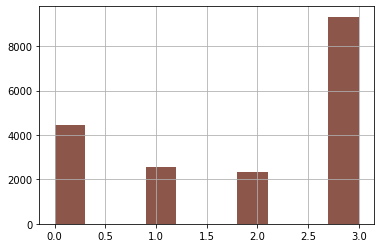

In [29]:
# cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [30]:
weights = {'lbg': 0.4, 'cat': 0, 'xgb': 0.4, 'nn': 0.20}

final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [31]:
pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

NameError: name 'cat_model' is not defined

{0: 0.9284050787477522, 1: 1.690212385918184, 2: 2.223646200306794}


3    0.499
0    0.239
1    0.137
2    0.125
Name: accuracy_group, dtype: float64

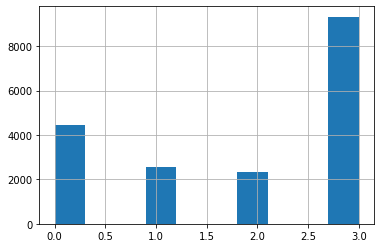

In [32]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)